### Load Libraries

In [ ]:
!pip install mapclassify

In [ ]:
# import numpy as np
import mapclassify

In [ ]:
!pip install geopandas
!pip install contextily
!pip install seaborn
# !pip install datashader

In [ ]:
import numpy as np
import pandas as pd
import geopandas
import matplotlib.pyplot as plt
from shapely import geometry
from shapely.geometry import Point
from shapely import wkt
from tqdm import tqdm
from scipy.spatial.distance import cdist
import pathlib
import contextily as cx
import seaborn
# import datashader
from google.colab import files

### Load Dataset

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
COURSE_DATASETS_PATH = pathlib.Path("/content/drive/MyDrive/SDS_project/")
COURSE_DATASETS_PATH.resolve()

PosixPath('/content/drive/MyDrive/SDS_project')

In [ ]:
house_price_data = pd.read_csv(COURSE_DATASETS_PATH / "Pakistan_House_Price_Prediction.csv")

In [ ]:
house_price_data.shape

(168446, 18)

In [ ]:
house_price_data.head()

,Unnamed: 0,property_id,location_id,page_url,property_type,price,location,city,province_name,latitude,longitude,baths,purpose,bedrooms,date_added,agency,agent,Total_Area
0,0,237062,3325,https://www.zameen.com/Property/g_10_g_10_2_gr...,Flat,10000000,G-10,Islamabad,Islamabad Capital,33.679890,73.012640,2,For Sale,2,2/4/2019,NaN,NaN,1089.004
1,1,346905,3236,https://www.zameen.com/Property/e_11_2_service...,Flat,6900000,E-11,Islamabad,Islamabad Capital,33.700993,72.971492,3,For Sale,3,5/4/2019,NaN,NaN,15246.056
2,2,386513,764,https://www.zameen.com/Property/islamabad_g_15...,House,16500000,G-15,Islamabad,Islamabad Capital,33.631486,72.926559,6,For Sale,5,7/17/2019,NaN,NaN,2178.008
3,3,656161,340,https://www.zameen.com/Property/islamabad_bani...,House,43500000,Bani Gala,Islamabad,Islamabad Capital,33.707573,73.151199,4,For Sale,4,4/5/2019,NaN,NaN,10890.000
4,4,841645,3226,https://www.zameen.com/Property/dha_valley_dha...,House,7000000,DHA Defence,Islamabad,Islamabad Capital,33.492591,73.301339,3,For Sale,3,7/10/2019,Easy Property,Muhammad Junaid Ceo Muhammad Shahid Director,2178.008


### Clean Dataset: Remove Unneccessary Columns

In [55]:
# list of columns to drop
cols_to_drop = ['Unnamed: 0', 'property_id', 'location_id', 'page_url', 'baths', 'bedrooms', 'date_added', 'agency', 'agent']

# drop the columns
house_price_data.drop(cols_to_drop, axis=1, inplace=True)

house_price_data.shape

(168446, 9)

In [56]:
house_price_data.dropna(inplace=True)

In [57]:
house_price_data.drop_duplicates(inplace=True)

In [58]:
house_price_data.shape

(93879, 9)

Keep only Lahore Data

In [59]:
lahore = house_price_data[house_price_data['city'] == 'Lahore']
lahore = lahore[lahore['purpose'] == 'For Sale']

In [60]:
# list of columns to drop
cols_to_drop = ['city', 'province_name', 'purpose']

# drop the columns
lahore.drop(cols_to_drop, axis=1, inplace=True)

In [61]:
lahore = lahore.reset_index(drop=True)

### Data Analysis & Visualization

In [62]:
lahore.shape

(21673, 6)

In [63]:
lahore.head()

,property_type,price,location,latitude,longitude,Total_Area
0,House,220000000,Model Town,31.483869,74.325686,32670.000
1,House,40000000,Multan Road,31.431593,74.179980,5445.000
2,House,9500000,Eden,31.499348,74.416959,2450.259
3,House,125000000,Gulberg,31.522069,74.355512,5445.000
4,House,21000000,Allama Iqbal Town,31.506483,74.286017,2994.761


In [64]:
lahore = lahore[lahore['property_type']!='Room']

In [65]:
lahore['location'].unique()
lahore['property_type'].unique()
# lahore['price'].unique()

array(['House', 'Flat', 'Lower Portion', 'Farm House', 'Penthouse',
       'Upper Portion'], dtype=object)

In [66]:
# create a GeoDataFrame from the cleaned dataset
lahore_geoms = geopandas.points_from_xy(x = lahore["longitude"], 
                                                      y = lahore["latitude"],
                                                      crs = "EPSG:4326") 

lahore_geotable = geopandas.GeoDataFrame(lahore, geometry = lahore_geoms)

In [67]:
lahore_geotable.head()

,property_type,price,location,latitude,longitude,Total_Area,geometry
0,House,220000000,Model Town,31.483869,74.325686,32670.000,POINT (74.32569 31.48387)
1,House,40000000,Multan Road,31.431593,74.179980,5445.000,POINT (74.17998 31.43159)
2,House,9500000,Eden,31.499348,74.416959,2450.259,POINT (74.41696 31.49935)
3,House,125000000,Gulberg,31.522069,74.355512,5445.000,POINT (74.35551 31.52207)
4,House,21000000,Allama Iqbal Town,31.506483,74.286017,2994.761,POINT (74.28602 31.50648)


In [68]:
lahore_geotable.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World.
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984 ensemble
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [69]:
type(lahore_geotable)

geopandas.geodataframe.GeoDataFrame

In [70]:
lahore['latitude'].min(), lahore['latitude'].max()

(31.23484745, 33.74946419)

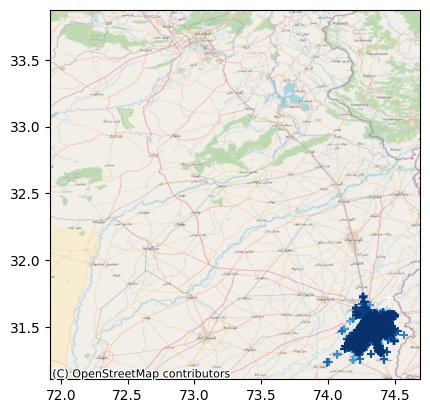

In [71]:
f, axs = plt.subplots()
lahore_geotable.plot(ax = axs, marker="+", cmap = "Blues")       # cmap: hsv, twilight_shifted, PuRd

cx.add_basemap(axs, crs = lahore_geotable.crs, source = cx.providers.OpenStreetMap.Mapnik);

### Removing Outlier locations

In [72]:
# calculate the pairwise distances between all house locations using the haversine formula
house_distances = cdist(lahore_geotable[['latitude', 'longitude']], lahore_geotable[['latitude', 'longitude']], metric='euclidean')

# calculate the average distance between houses
avg_distance = house_distances.mean()

In [73]:
# remove houses that are more than 2 times the average distance from the median location
median_location = lahore_geotable[['latitude', 'longitude']].median()
distances_from_median = cdist(median_location.values.reshape(1, -1), lahore_geotable[['latitude', 'longitude']], metric='euclidean')[0]
lahore_geotable = lahore_geotable[distances_from_median <= 2 * avg_distance]

In [74]:
lahore_geotable.shape

(21647, 7)

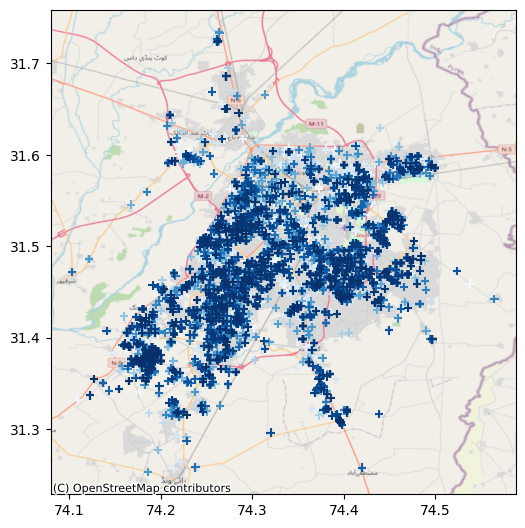

In [75]:
f, axs = plt.subplots(figsize = (6, 10))
lahore_geotable.plot(ax = axs, marker="+", cmap = "Blues")

cx.add_basemap(axs, crs = lahore_geotable.crs, source = cx.providers.OpenStreetMap.Mapnik);

### Add new columns that will be needed
Column containing all the tags in the surrounding area

In [ ]:
!pip install numpy==1.23.0
!pip install scipy==1.7.0
!pip install osmnx

In [ ]:
import osmnx as ox

### Tags Count columns

The next 9 cells need not be run as resultant GPKG file is provided.

In [77]:
# list of tags to retrieve
d_tags = {
    "building":["residential", "apartments", "terrace", "house", "detached", "semidetached_house", "commercial", "office", "retail", "supermarket"],
    "amenity":["school", "college", "university", "hospital", "clinic", "pharmacy"], 
    "highway":"bus_stop",
    'leisure': 'park'
}

In [78]:
living = ['residential', 'apartments', 'terrace', 'house', 'detached', 'semidetached_house']
commercial = [ 'commercial', 'office', 'retail', 'supermarket']
school = ['school', 'college', 'university']
hospital = ['hospital', 'clinic', 'pharmacy']

In [ ]:
living_counts = []
commercial_counts = []
school_counts = []
hospital_counts = []
park = []
bus_stop = []
for idx in tqdm(range(len(lahore_geotable))):
    row = lahore.iloc[idx]
    cp = row['latitude'], row['longitude']
    for key, value in d_tags.items():
        tag = dict()
        tag[key] = d_tags[key]
        tags_gdf = ox.geometries.geometries_from_point(cp, tags=tag, dist=500)
        if key == "building":
            if len(tags_gdf):
                living_counts.append(len(tags_gdf[tags_gdf['building'].isin(living)]))
                commercial_counts.append(len(tags_gdf[tags_gdf['building'].isin(commercial)]))
            else:
                living_counts.append(0)
                commercial_counts.append(0)
        elif key == "amenity":
            if len(tags_gdf):
                school_counts.append(len(tags_gdf[tags_gdf['amenity'].isin(school)]))
                hospital_counts.append(len(tags_gdf[tags_gdf['amenity'].isin(hospital)]))
            else:
                school_counts.append(0)
                hospital_counts.append(0)
            #     school.append(True)
            # else:
            #     school.append(False)
        elif key == "highway":
            if len(tags_gdf):
                bus_stop.append(True)
            else:
                bus_stop.append(False)
        elif key == "leisure":
            if len(tags_gdf):
                park.append(True)
            else:
                park.append(False)

In [ ]:
len(living_counts), len(commercial_counts), len(school_counts), len(hospital_counts), len(park), len(bus_stop)

In [ ]:
# lahore_filter = lahore_geotable.iloc[:11, :]

In [ ]:
lahore_geotable["living"] = living_counts
lahore_geotable["commercial"] = commercial_counts
lahore_geotable["school"] = school_counts
lahore_geotable["hospital"] = hospital_counts
lahore_geotable["park"] = park
lahore_geotable["bus_stop"] = bus_stop

In [ ]:
lahore_geotable.tail()

In [ ]:
output_path = 'output.gpkg'
lahore_geotable.to_file(output_path, driver='GPKG')

In [ ]:
files.download(output_path)

Restart Executing from here.

In [ ]:
gpkg_path = '/content/drive/MyDrive/SDS_project/output.gpkg'

lahore_geotable = geopandas.read_file(gpkg_path)

In [ ]:
lahore_geotable = lahore_geotable.rename(columns={'living counts': 'living'})

lahore_geotable.head()

,property_type,price,location,latitude,longitude,Total_Area,living,commercial,school,hospital,park,bus_stop,geometry
0,House,220000000,Model Town,31.483869,74.325686,32670.000,0,0,7,1,True,False,POINT (74.32569 31.48387)
1,House,40000000,Multan Road,31.431593,74.179980,5445.000,0,0,0,0,False,False,POINT (74.17998 31.43159)
2,House,9500000,Eden,31.499348,74.416959,2450.259,1363,28,0,0,True,False,POINT (74.41696 31.49935)
3,House,125000000,Gulberg,31.522069,74.355512,5445.000,25,54,2,0,True,False,POINT (74.35551 31.52207)
4,House,21000000,Allama Iqbal Town,31.506483,74.286017,2994.761,0,0,2,0,True,False,POINT (74.28602 31.50648)


### Area Boundaries column

The following 6 cells generate the provided boundaries.gpkg file so need not be run.

In [79]:
location_names = lahore_geotable['location']
location_names

0               Model Town
1              Multan Road
2                     Eden
3                  Gulberg
4        Allama Iqbal Town
               ...        
21668          Bahria Town
21669                NFC 1
21670          Bahria Town
21671          DHA Defence
21672            Lake City
Name: location, Length: 21647, dtype: object

In [ ]:
# Define the location names to extract
location_names = lahore_geotable['location']

# Define the place name for OSM search
place_name = 'Lahore, Pakistan'

# Get the OSM data for the place
place_gdf = ox.geocode_to_gdf(place_name)

# Create an empty GeoDataFrame to store the extracted boundaries
boundaries_gdf = geopandas.GeoDataFrame()

# Loop through each location name and extract its boundary
for name in tqdm(location_names, desc='Extracting boundaries'):
    # Get the subset of the data for the current location name
    subset_gdf = lahore_geotable[lahore_geotable['location'] == name]
    
    # Spatial join with the OSM data to get the boundary
    join_gdf = geopandas.sjoin(subset_gdf, place_gdf, op='within')
    
    # Append the boundary to the output GeoDataFrame
    boundaries_gdf = boundaries_gdf.append(join_gdf)

In [ ]:
boundaries_gdf.shape

In [ ]:
# Print the boundaries GeoDataFrame
boundaries_gdf

In [ ]:
boundaries_gdf = boundaries_gdf.set_geometry('geometry')
boundaries_gdf = boundaries_gdf.set_crs(epsg=4326)

In [ ]:
# Write the boundaries GeoDataFrame to a GPKG file
boundaries_gdf.to_file('boundaries.gpkg', layer='location_boundaries', driver='GPKG')

Resume execution from here.

In [ ]:
gpkg_path = '/content/drive/MyDrive/SDS_project/boundaries.gpkg'

boundaries_geotable = geopandas.read_file(gpkg_path, layer='location_boundaries')

In [ ]:
boundaries_geotable

,property_type,price,location,latitude,longitude,Total_Area,living,commercial,school,hospital,...,place_id,osm_type,osm_id,lat,lon,display_name,class,type,importance,geometry
0,House,9000000,Model Town,31.466373,74.315983,1361.255,0,1,1,1,...,255501707,way,765212654,31.468965,74.317506,"72 MB Floor Zainab tower, Link road, Model tow...",landuse,commercial,0.42,POINT (74.31598 31.46637)
1,House,40000000,Model Town,31.466373,74.315983,5445.000,74,0,0,0,...,255501707,way,765212654,31.468965,74.317506,"72 MB Floor Zainab tower, Link road, Model tow...",landuse,commercial,0.42,POINT (74.31598 31.46637)
2,House,13000000,Model Town,31.466373,74.315983,1905.757,0,0,0,0,...,255501707,way,765212654,31.468965,74.317506,"72 MB Floor Zainab tower, Link road, Model tow...",landuse,commercial,0.42,POINT (74.31598 31.46637)
3,House,105000000,Model Town,31.466373,74.315983,10890.000,0,0,0,0,...,255501707,way,765212654,31.468965,74.317506,"72 MB Floor Zainab tower, Link road, Model tow...",landuse,commercial,0.42,POINT (74.31598 31.46637)
4,House,12000000,Model Town,31.466373,74.315990,1361.255,0,0,0,0,...,255501707,way,765212654,31.468965,74.317506,"72 MB Floor Zainab tower, Link road, Model tow...",landuse,commercial,0.42,POINT (74.31599 31.46637)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6817,House,8500000,Model Town,31.466373,74.315983,1361.255,1,0,1,1,...,255501707,way,765212654,31.468965,74.317506,"72 MB Floor Zainab tower, Link road, Model tow...",landuse,commercial,0.42,POINT (74.31598 31.46637)
6818,House,6500000,Model Town,31.466373,74.315983,816.753,0,0,4,2,...,255501707,way,765212654,31.468965,74.317506,"72 MB Floor Zainab tower, Link road, Model tow...",landuse,commercial,0.42,POINT (74.31598 31.46637)
6819,House,37500000,Model Town,31.466373,74.315983,5445.000,0,0,1,0,...,255501707,way,765212654,31.468965,74.317506,"72 MB Floor Zainab tower, Link road, Model tow...",landuse,commercial,0.42,POINT (74.31598 31.46637)
6820,House,6000000,Model Town,31.466373,74.315983,816.753,62,0,0,0,...,255501707,way,765212654,31.468965,74.317506,"72 MB Floor Zainab tower, Link road, Model tow...",landuse,commercial,0.42,POINT (74.31598 31.46637)


### Data Analysis and Visualiztion

### Correlation

In [38]:
lahore_geotable["price_std"] = lahore_geotable["price"] - lahore_geotable["price"].mean()
lahore_geotable["living_std"] = lahore_geotable["living"] - lahore_geotable["living"].mean()
lahore_geotable["commercial_std"] = lahore_geotable["commercial"] - lahore_geotable["commercial"].mean()
lahore_geotable["school_std"] = lahore_geotable["school"] - lahore_geotable["school"].mean()
lahore_geotable["hospital_std"] = lahore_geotable["hospital"] - lahore_geotable["hospital"].mean()
lahore_geotable["park_std"] = lahore_geotable["park"] - lahore_geotable["park"].mean()
lahore_geotable["bus_stop_std"] = lahore_geotable["bus_stop"] - lahore_geotable["bus_stop"].mean()
lahore_geotable["Total_Area_std"] = lahore_geotable["Total_Area"] - lahore_geotable["Total_Area"].mean()

In [ ]:
print(lahore_geotable["price"].mean(), lahore_geotable["living"].mean())

26195112.719961196 64.26040559892826


In [ ]:
print(lahore_geotable["price_std"].min(), lahore_geotable["price_std"].max())

-26195111.719961196 1973804887.2800388


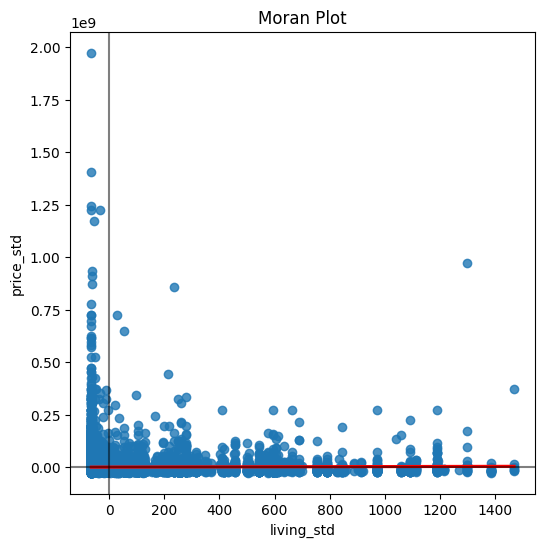

In [39]:
f, ax = plt.subplots(1, figsize=(6, 6))
seaborn.regplot(
    x="living_std",
    y="price_std",
    ci=None,
    data=lahore_geotable,
    line_kws={"color": "r"},
)
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title("Moran Plot")
plt.show()

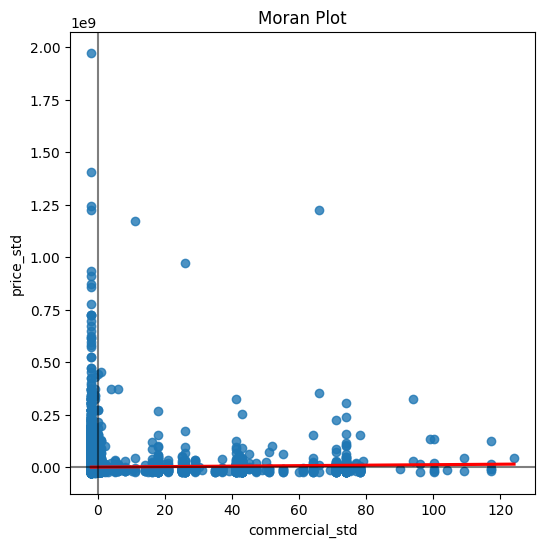

In [43]:
f, ax = plt.subplots(1, figsize=(6, 6))
seaborn.regplot(
    x="commercial_std",
    y="price_std",
    ci=None,
    data=lahore_geotable,
    line_kws={"color": "r"},
)
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title("Moran Plot")
plt.show()

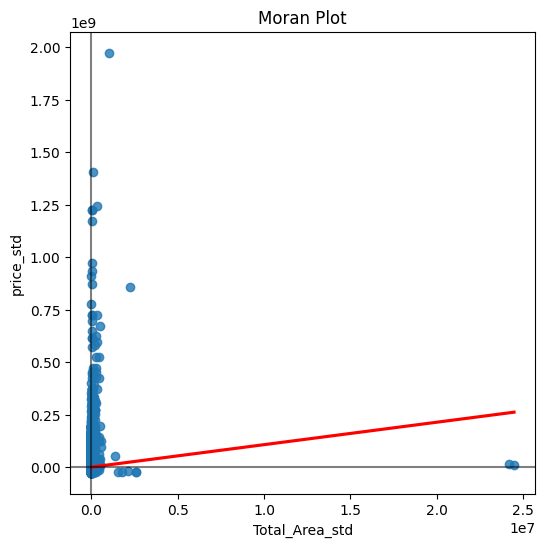

In [42]:
f, ax = plt.subplots(1, figsize=(6, 6))
seaborn.regplot(
    x="Total_Area_std",
    y="price_std",
    ci=None,
    data=lahore_geotable,
    line_kws={"color": "r"},
)
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title("Moran Plot")
plt.show()

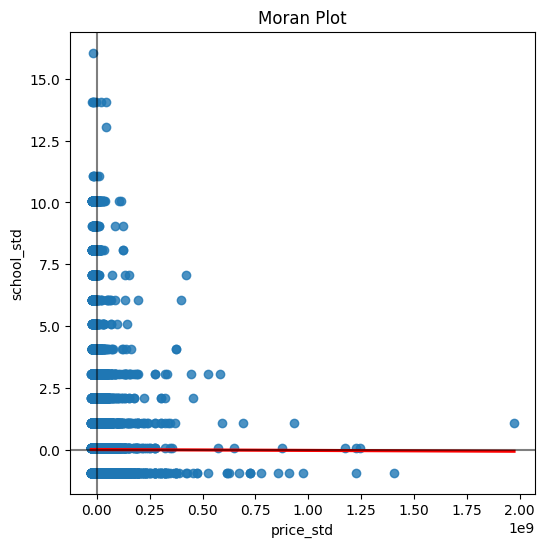

In [41]:
f, ax = plt.subplots(1, figsize=(6, 6))
seaborn.regplot(
    x="price_std",
    y="school_std",
    ci=None,
    data=lahore_geotable,
    line_kws={"color": "r"},
)
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title("Moran Plot")
plt.show()

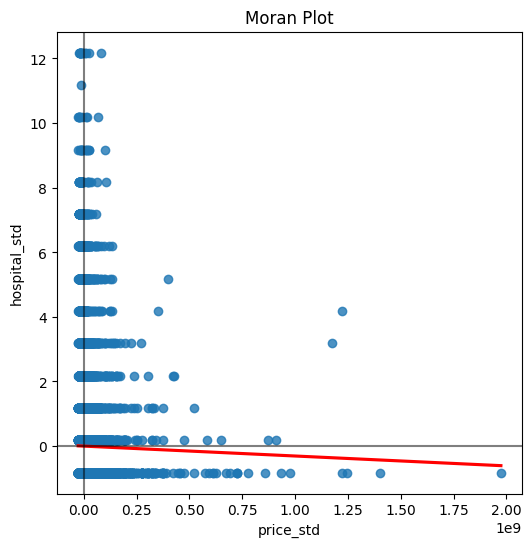

In [40]:
f, ax = plt.subplots(1, figsize=(6, 6))
seaborn.regplot(
    x="price_std",
    y="hospital_std",
    ci=None,
    data=lahore_geotable,
    line_kws={"color": "r"},
)
ax.axvline(0, c="k", alpha=0.5)
ax.axhline(0, c="k", alpha=0.5)
ax.set_title("Moran Plot")
plt.show()

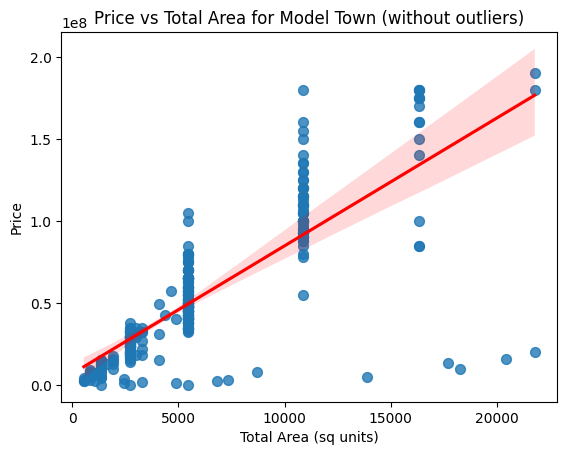

In [44]:
location = "Model Town"
filtered_data = lahore_geotable[lahore_geotable['location'] == location]

# Calculate the Interquartile Range (IQR) for price and Total_Area
Q1_price = filtered_data['price'].quantile(0.25)
Q3_price = filtered_data['price'].quantile(0.75)
IQR_price = Q3_price - Q1_price

Q1_area = filtered_data['Total_Area'].quantile(0.25)
Q3_area = filtered_data['Total_Area'].quantile(0.75)
IQR_area = Q3_area - Q1_area

# Remove outliers based on the IQR
filtered_data_no_outliers = filtered_data[
    (filtered_data['price'] >= (Q1_price - 1.5 * IQR_price)) &
    (filtered_data['price'] <= (Q3_price + 1.5 * IQR_price)) &
    (filtered_data['Total_Area'] >= (Q1_area - 1.5 * IQR_area)) &
    (filtered_data['Total_Area'] <= (Q3_area + 1.5 * IQR_area))
]

# Create a scatterplot with price on the y-axis and Total_Area on the x-axis
seaborn.regplot(data=filtered_data_no_outliers, x='Total_Area', y='price', scatter_kws={'s': 50}, line_kws={'color': 'red'})

# Set the title and labels for the plot
plt.title(f"Price vs Total Area for {location} (without outliers)")
plt.xlabel("Total Area (sq units)")
plt.ylabel("Price")

# Display the plot
plt.show()


#### Comparitive Analysis of House Price, Commercial Value & Area by Location

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


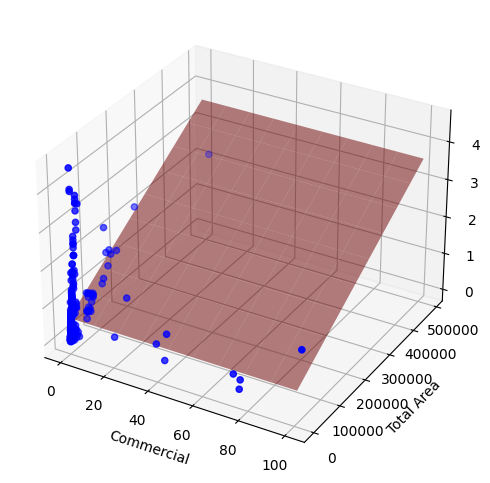

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

model_town_data = lahore_geotable[lahore_geotable['location'] == 'Model Town']

X = model_town_data[['commercial', 'Total_Area']]
y = model_town_data['price']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
regressor = LinearRegression()
regressor.fit(X_train, y_train)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the actual data
ax.scatter(X_train['commercial'], X_train['Total_Area'], y_train, color='b', label='Actual Data')

# Plot the regression plane
xx1, xx2 = np.meshgrid(np.linspace(X_train['commercial'].min(), X_train['commercial'].max(), 10),
                       np.linspace(X_train['Total_Area'].min(), X_train['Total_Area'].max(), 10))

yy = regressor.predict(np.column_stack((xx1.ravel(), xx2.ravel())))
yy = yy.reshape(xx1.shape)

ax.plot_surface(xx1, xx2, yy, color='r', alpha=0.5, label='Regression Plane')

ax.set_xlabel('Commercial')
ax.set_ylabel('Total Area')
ax.set_zlabel('Price')

plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


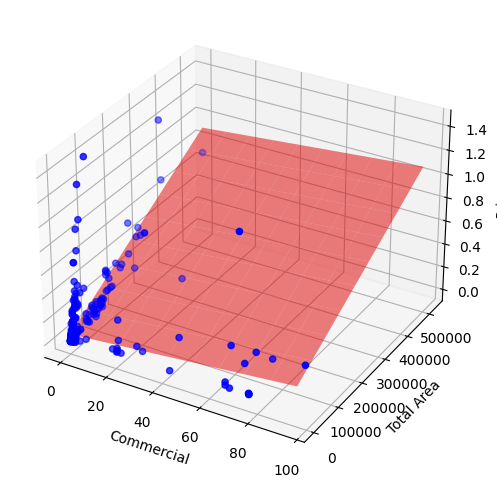

In [49]:
gulberg_data = lahore_geotable[lahore_geotable['location'] == 'Gulberg']

X = gulberg_data[['commercial', 'Total_Area']]
y = gulberg_data['price']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
regressor = LinearRegression()
regressor.fit(X_train, y_train)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the actual data
ax.scatter(X_train['commercial'], X_train['Total_Area'], y_train, color='b', label='Actual Data')

# Plot the regression plane
xx1, xx2 = np.meshgrid(np.linspace(X_train['commercial'].min(), X_train['commercial'].max(), 10),
                       np.linspace(X_train['Total_Area'].min(), X_train['Total_Area'].max(), 10))

yy = regressor.predict(np.column_stack((xx1.ravel(), xx2.ravel())))
yy = yy.reshape(xx1.shape)

ax.plot_surface(xx1, xx2, yy, color='r', alpha=0.5, label='Regression Plane')

ax.set_xlabel('Commercial')
ax.set_ylabel('Total Area')
ax.set_zlabel('Price')

plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


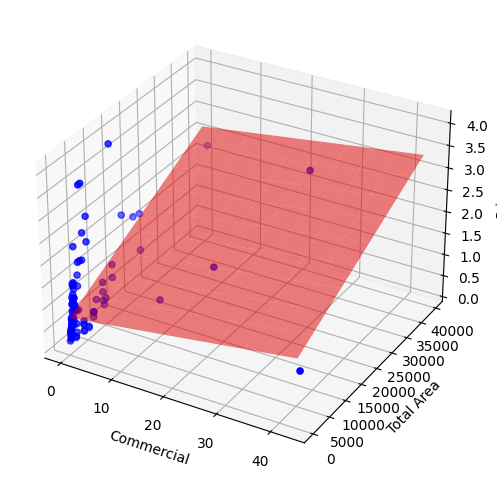

In [51]:
MR_data = lahore_geotable[lahore_geotable['location'] == 'Multan Road']

X = MR_data[['commercial', 'Total_Area']]
y = MR_data['price']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
regressor = LinearRegression()
regressor.fit(X_train, y_train)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the actual data
ax.scatter(X_train['commercial'], X_train['Total_Area'], y_train, color='b', label='Actual Data')

# Plot the regression plane
xx1, xx2 = np.meshgrid(np.linspace(X_train['commercial'].min(), X_train['commercial'].max(), 10),
                       np.linspace(X_train['Total_Area'].min(), X_train['Total_Area'].max(), 10))

yy = regressor.predict(np.column_stack((xx1.ravel(), xx2.ravel())))
yy = yy.reshape(xx1.shape)

ax.plot_surface(xx1, xx2, yy, color='r', alpha=0.5, label='Regression Plane')

ax.set_xlabel('Commercial')
ax.set_ylabel('Total Area')
ax.set_zlabel('Price')

plt.show()


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


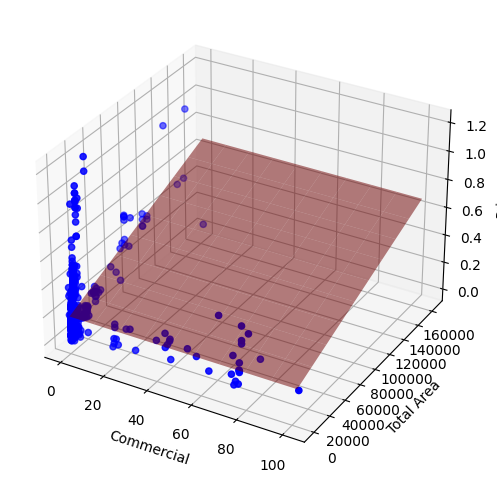

In [54]:
Bahria_data = lahore_geotable[lahore_geotable['location'] == 'Bahria Town']

X = Bahria_data[['commercial', 'Total_Area']]
y = Bahria_data['price']


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
regressor = LinearRegression()
regressor.fit(X_train, y_train)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')

# Plot the actual data
ax.scatter(X_train['commercial'], X_train['Total_Area'], y_train, color='b', label='Actual Data')

# Plot the regression plane
xx1, xx2 = np.meshgrid(np.linspace(X_train['commercial'].min(), X_train['commercial'].max(), 10),
                       np.linspace(X_train['Total_Area'].min(), X_train['Total_Area'].max(), 10))

yy = regressor.predict(np.column_stack((xx1.ravel(), xx2.ravel())))
yy = yy.reshape(xx1.shape)

ax.plot_surface(xx1, xx2, yy, color='r', alpha=0.5, label='Regression Plane')

ax.set_xlabel('Commercial')
ax.set_ylabel('Total Area')
ax.set_zlabel('Price')

plt.show()


<ipython-input-46-83520a822ef5>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correlation_df['park'] = correlation_df['park'].astype(int)
<ipython-input-46-83520a822ef5>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  correlation_df['bus_stop'] = correlation_df['bus_stop'].astype(int)


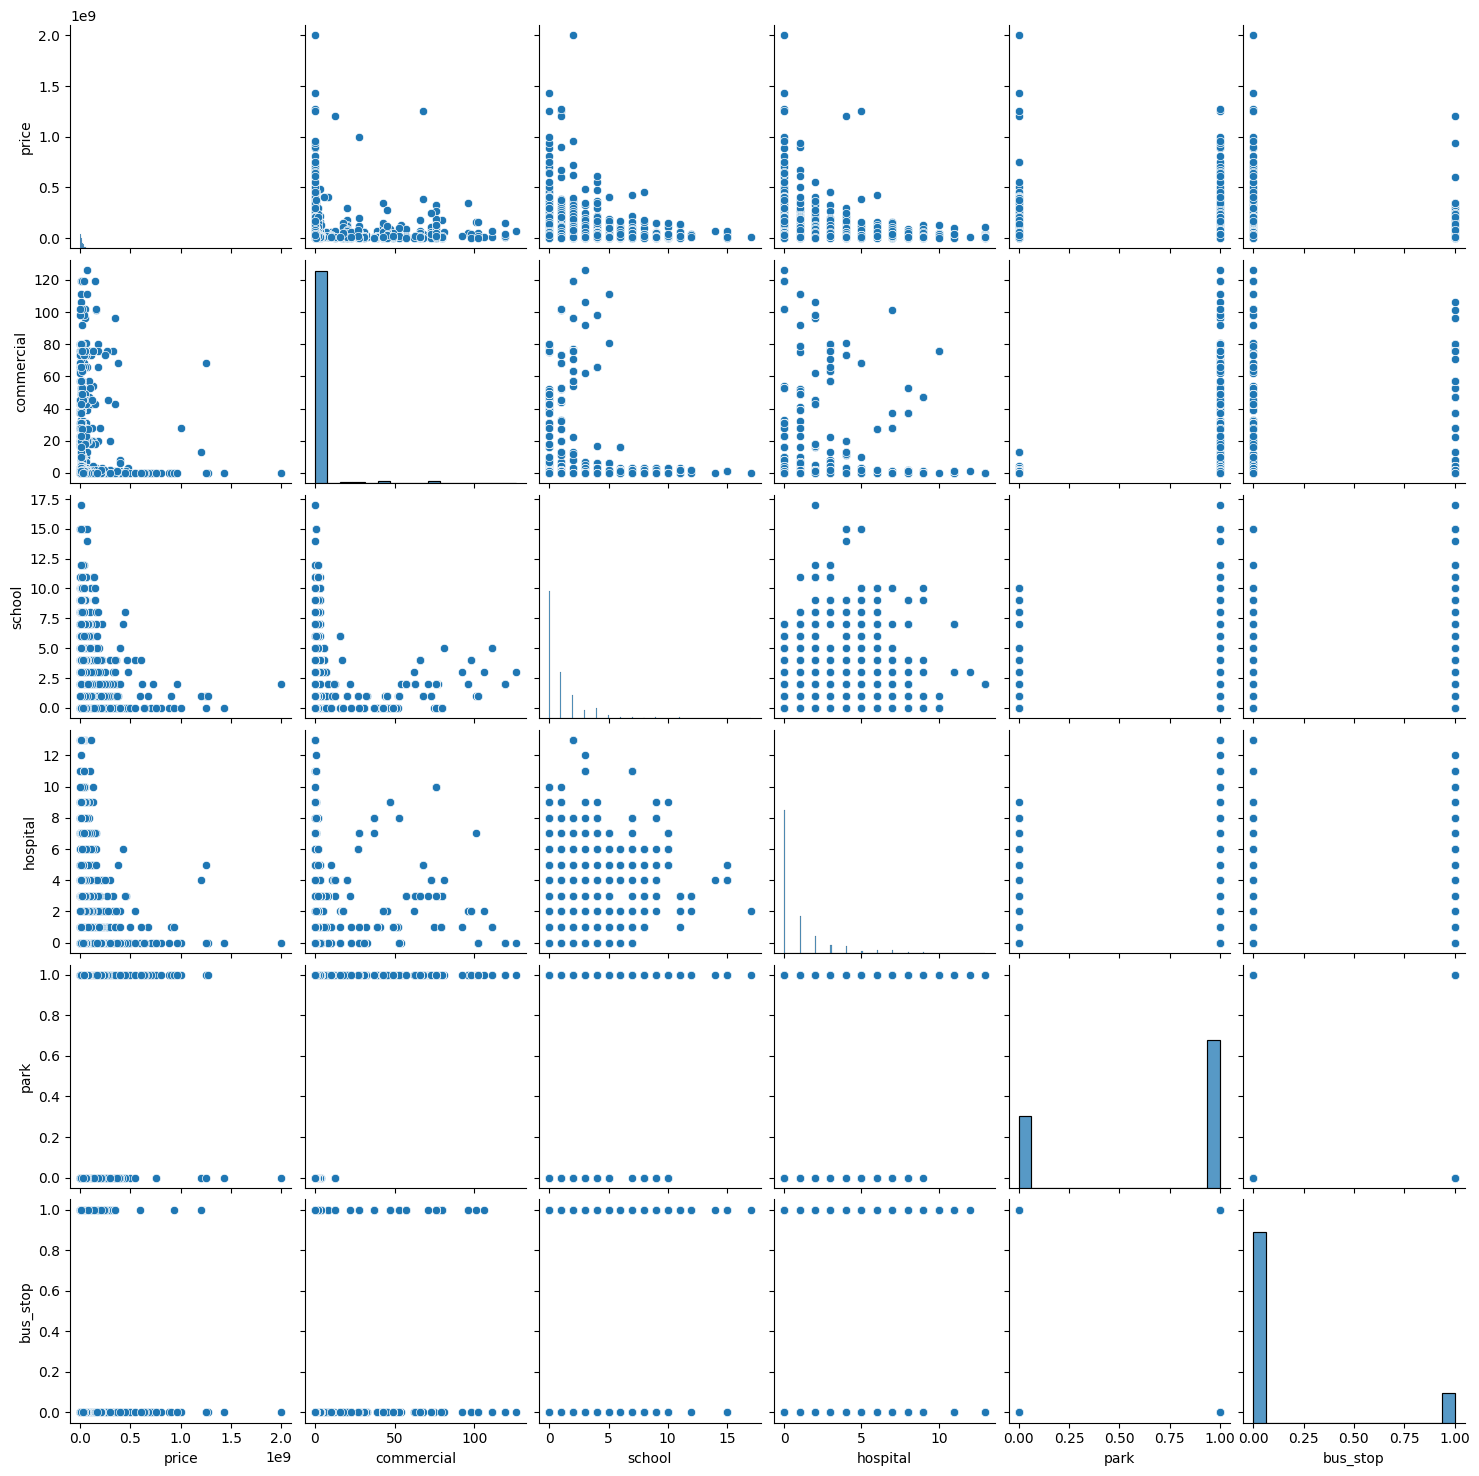

In [46]:
# Create a DataFrame with the relevant columns
correlation_df = lahore_geotable[['price', 'commercial', 'school', 'hospital', 'park', 'bus_stop']]

# Convert boolean columns 'park' and 'bus_stop' to integers (True = 1, False = 0)
correlation_df['park'] = correlation_df['park'].astype(int)
correlation_df['bus_stop'] = correlation_df['bus_stop'].astype(int)

# Create pairplot
seaborn.pairplot(correlation_df)

# Show the plots
plt.show()

In [ ]:
# from splot.esda import plot_moran

In [ ]:
# moran.I

In [ ]:
# moran.p_sim

In [ ]:
# plot_moran(moran);

### Clustering and Regionalization

In [ ]:
# Plot the boundaries GeoDataFrame
fig, ax = plt.subplots(figsize=(10, 10))
boundaries_geotable.plot(ax=ax)
plt.show()

In [ ]:
# Plot the boundaries GeoDataFrame
ax = boundaries_geotable.plot(figsize=(6, 10))

# Add title and axis labels
ax.set_title('Boundaries of Locations in Lahore')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')

# Show the plot
plt.show()

In [ ]:
cluster_variables = ["price", "Total_Area", "living", "commercial", "school", "hospital", "park", "bus_stop"]

In [ ]:
f, axs = plt.subplots(nrows=3, ncols=3, figsize=(12, 12))
# Make the axes accessible with single indexing
axs = axs.flatten()

# Start a loop over all the variables of interest
for i, col in enumerate(cluster_variables):
    # select the axis where the map will go
    ax = axs[i]
    # Plot the map
    boundaries_geotable.plot(
        column=col,
        ax=ax,
        scheme="Quantiles",
        linewidth=0,
        cmap="RdPu",
    )
    
    # Remove axis clutter
    ax.set_axis_off()
    # Set the axis title to the name of variable being plotted
    ax.set_title(col)

# Display the figure
plt.show()